### Učitavanje potrebnih biblioteka

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import os
import shutil
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm


### Postavljanje seta podataka (Dataset)

In [6]:
class FaceDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

Koristi se baza slika lica "Labelled Faces in the Wild (LFW) Dataset"
https://www.kaggle.com/datasets/jessicali9530/lfw-dataset

In [7]:
DATA_DIR = '../data/people/'

In [8]:
dataset = FaceDataset(
    data_dir = DATA_DIR
)

In [9]:
print("Veličina seta podataka:", len(dataset))

Veličina seta podataka: 13233


410


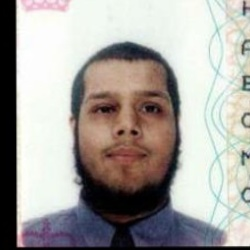

In [10]:
image, label = dataset[1000]
print(label)
image

In [11]:
target_to_class = {v: k for k, v in ImageFolder(DATA_DIR).class_to_idx.items()}
print(target_to_class)

{0: 'AJ_Cook', 1: 'AJ_Lamas', 2: 'Aaron_Eckhart', 3: 'Aaron_Guiel', 4: 'Aaron_Patterson', 5: 'Aaron_Peirsol', 6: 'Aaron_Pena', 7: 'Aaron_Sorkin', 8: 'Aaron_Tippin', 9: 'Abba_Eban', 10: 'Abbas_Kiarostami', 11: 'Abdel_Aziz_Al-Hakim', 12: 'Abdel_Madi_Shabneh', 13: 'Abdel_Nasser_Assidi', 14: 'Abdoulaye_Wade', 15: 'Abdul_Majeed_Shobokshi', 16: 'Abdul_Rahman', 17: 'Abdulaziz_Kamilov', 18: 'Abdullah', 19: 'Abdullah_Ahmad_Badawi', 20: 'Abdullah_Gul', 21: 'Abdullah_Nasseef', 22: 'Abdullah_al-Attiyah', 23: 'Abdullatif_Sener', 24: 'Abel_Aguilar', 25: 'Abel_Pacheco', 26: 'Abid_Hamid_Mahmud_Al-Tikriti', 27: 'Abner_Martinez', 28: 'Abraham_Foxman', 29: 'Aby_Har-Even', 30: 'Adam_Ant', 31: 'Adam_Freier', 32: 'Adam_Herbert', 33: 'Adam_Kennedy', 34: 'Adam_Mair', 35: 'Adam_Rich', 36: 'Adam_Sandler', 37: 'Adam_Scott', 38: 'Adel_Al-Jubeir', 39: 'Adelina_Avila', 40: 'Adisai_Bodharamik', 41: 'Adolfo_Aguilar_Zinser', 42: 'Adolfo_Rodriguez_Saa', 43: 'Adoor_Gopalakarishnan', 44: 'Adrian_Annus', 45: 'Adrian_Ferna

In [12]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = FaceDataset(DATA_DIR, transform)

In [13]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

### Učitavanje podataka (Dataloaders)

In [14]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### PyTorch model

In [15]:
class FaceClassifer(nn.Module):
    def __init__(self, num_classes):
        super(FaceClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [16]:
model = FaceClassifer(num_classes=len(dataset))
print(str(model)[:500])

FaceClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
  


## Treniranje modela

In [17]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'config' (most likely due to a circular import)

### Postavljanje setova podataka (datasets)

In [ ]:
import os
import shutil
import random

main_data_folder = '../data/people/'
train_folder = '../data/train/'
valid_folder = '../data/valid/'
test_folder = '../data/test/'

# Remove existing train, valid, and test folders (if they exist)
for folder in [train_folder, valid_folder, test_folder]:
    if os.path.exists(folder):
        shutil.rmtree(folder)  # Delete the folder and its contents

# Create destination folders
for folder in [train_folder, valid_folder, test_folder]:
    os.makedirs(folder, exist_ok=True)

for class_name in os.listdir(main_data_folder):
    class_path = os.path.join(main_data_folder, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip non-folder items

    # List all images in the class folder
    images = os.listdir(class_path)
    random.shuffle(images)  # Shuffle images for randomness

    total_images = len(images)
    
    # Skip classes with fewer than 3 images
    if total_images < 3:
        print(f"Skipping class {class_name}: only {total_images} image(s).")
        continue

    # Create class subfolders in train, valid, and test directories
    os.makedirs(os.path.join(train_folder, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_folder, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_folder, class_name), exist_ok=True)

    # Ensure at least 1 image in test and 1 in validation
    test_images = images[:1]  # First image for testing
    valid_images = images[1:2]  # Second image for validation
    train_images = images[2:]  # Remaining images for training

    # Move images to respective folders
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_folder, class_name, img))
    for img in valid_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(valid_folder, class_name, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_folder, class_name, img))

    print(f"Class {class_name}: {len(train_images)} train, {len(valid_images)} valid, {len(test_images)} test images.")


In [94]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '../data/train/'
valid_folder = '../data/valid/'
test_folder = '../data/test/'

train_dataset = FaceDataset(train_folder, transform=transform)
val_dataset = FaceDataset(valid_folder, transform=transform)
test_dataset = FaceDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = FaceClassifer(num_classes=len(dataset))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")